<a href="https://colab.research.google.com/github/mehrdad-bhm/Gen-AI/blob/main/Model_A%26D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Install Python packages
!pip install -q -U datasets
!pip install -q -U auto-gptq
!pip install -q -U optimum                                                                         # For GPTQ Optimization
!pip install -q -U bitsandbytes                                                                       # For quantization
!pip install -q -U peft                                                                               # Parameter-efficient Fine-tuning
!pip install -q -U accelerate                                                                         # Loading models across GPUs/CPU/disk
!pip install -q -U evaluate
!pip install -q -U transformers
!pip install -q -U trl


In [ ]:
# @title Import libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import bitsandbytes as bnb
import pandas as pd
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from transformers import AdamW
import evaluate
from trl import SFTTrainer
from torch.utils.data import DataLoader
from peft import (
    LoraConfig,
    PeftConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)

## 1.Load Dataset

In [ ]:
dataset = load_dataset("mbpp")

#---------------------------------------------------
def format_instruction(text, code):
	return f"""
<Human>: {text.strip()}
<AI>: {code}
  """.strip()				# Meta recommends using strip() to get rid of extra spaces


#---------------------------------------------------
def convert_to_instruction_format(data_point):
    return {"sample": format_instruction(data_point["text"], data_point["code"])}


#---------------------------------------------------
def process_test_dataset(data):
    return data.map(convert_to_instruction_format).remove_columns(['task_id','test_list', 'test_setup_code', 'challenge_test_list'])

def process_dataset(data):
    return data.map(convert_to_instruction_format).remove_columns(['task_id','test_list', 'test_setup_code', 'challenge_test_list'])

#---------------------------------------------------
num_train_samples = len(dataset["train"])
num_test_samples = len(dataset["test"])
num_validation_samples = len(dataset["validation"])

train_data = process_dataset(dataset["train"].shuffle(seed=42).select([i for i in range(200)]))
test_data = process_test_dataset(dataset["test"].shuffle(seed=42).select([i for i in range(50)]))
validation_data  = process_dataset(dataset["validation"].shuffle(seed=42).select([i for i in range(num_validation_samples)]))

## 2. Load a pre-trained model [Model A]

In [ ]:
# 1. Setup the quantization configuarion
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                     # Q = 4 bits
    bnb_4bit_use_double_quant=True,        # double quantization, quantizing the quantization constants for memory savings
    bnb_4bit_quant_type="nf4",             # 4-bit NormalFloat Quantization (optimal for normal weights; enforces w ∈ [-1,1])
    bnb_4bit_compute_dtype=torch.bfloat16  # Dequantize to 16-bits before computations (as in the paper)
)
# 2. Pass it while using the model
model = AutoModelForCausalLM.from_pretrained("croissantllm/CroissantLLMChat-v0.1", quantization_config=bnb_config, device_map="auto") # number of model parameters: 1.3B
tokenizer = AutoTokenizer.from_pretrained("croissantllm/CroissantLLMChat-v0.1")

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [ ]:
print(f"Number of model parameters: {model.num_parameters()}")

##3. Test model A on the testing dataset using the BLEU evaluation metric

In [ ]:
# Generate Data by Model A trough test Dataset
data_loader = DataLoader(test_data, batch_size=1)
generated_data_A = []

for batch in data_loader:
    input_ids = tokenizer(batch['text'], return_tensors='pt')
    with torch.no_grad():
        outputs = model.generate(**input_ids, max_new_tokens=50, do_sample=True, top_p=0.95, top_k=60, temperature=0.5, output_scores=True)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_data_A.append(generated_text)

In [ ]:
print(generated_data_A)

In [ ]:
bleu = evaluate.load("bleu")
results = bleu.compute(predictions= generated_data_A, references= test_data['sample'])
print(results)

##6. Use the designed prompt to generate a new synthesised dataset that has the nature and 3 times the size of the training dataset using the supported AWS model.


In [ ]:
# @title AWS config

import requests
import json

def llama_generate(prompt,
                   api_token,
                   max_gen_len = 512,
                   temperature = 0.5,
                   top_p =0.9):
  url = 'https://6xtdhvodk2.execute-api.us-west-2.amazonaws.com/dsa_llm/generate'
  body = {
    "prompt": prompt,
    "max_gen_len": max_gen_len,
    "temperature": temperature,
    "top_p": top_p,
    "api_token": api_token
  }
  res = requests.post(url,  json = body)
  return  json.loads(res.text)["body"]["generation"]

AWS_API_KEY = "your API KEY"

prompt = """
Generate two python lists, named intent and snippet, with at least 12 elements for each list. witout any explanation
intent list: Each element should be a question related to Python programming.
snippet list: Each element should be a valid Python code snippet that addresses the corresponding question in the intent list.
"""

In [ ]:
print(llama_generate(prompt, AWS_API_KEY))

In [ ]:
# @title Generated data on LLaMA2
generated_text = [
    "How do I print a message to the console in Python?",
    "How do I ask the user for input in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I modify the elements of a list in Python?",
    "How do I check if a number is negative, positive, or zero in Python?",
    "How do I convert a string to uppercase in Python?",
    "How do I create a dictionary in Python?",
    "How do I print a message in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add an element to a list in Python?",
    "How do I remove an element from a list in Python?",
    "How do I check if an element is in a list in Python?",
    "How do I sort a list in Python?",
    "How do I print a message in Python?",
    "How do I ask the user for input in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I modify the elements of a list in Python?",
    "How do I check if a number is negative, positive, or zero in Python?",
    "How do I convert a string to uppercase in Python?",
    "How do I create a dictionary in Python?",
    "How do I print a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I check if a number is negative, positive, or zero?",
    "How do I convert a string to uppercase in Python?",
    "How do I read a file line by line in Python?",
    "How do I write a list to a file in Python?",
    "How do I create a loop that runs 10 times in Python?",
    "How do I create a function that takes two arguments in Python?",
    "How do I create a list in Python?",
    "How do I access elements in a list?",
    "How do I add elements to a list?",
    "How do I remove elements from a list?",
    "How do I check if an element is in a list?",
    "How do I sort a list in Python?",
    "How do I reverse a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I print a message in Python?",
    "How do I create a list in Python?",
    "How do I access elements in a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add elements to a list in Python?",
    "How do I remove elements from a list in Python?",
    "How do I check if a value is in a list in Python?",
    "How do I sort a list in Python?",
    "How do I print a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I iterate through a list in Python?",
    "How do I filter a list in Python?",
    "How do I sort a list in Python?",
    "How do I create a list comprehension in Python?",
    "How do I use regular expressions in Python?",
    "How do I read a CSV file in Python?",
    "How do I print a message in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add an element to a list in Python?",
    "How do I remove an element from a list in Python?",
    "How do I check if an element is in a list in Python?",
    "How do I print a message to the console in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add an element to a list in Python?",
    "How do I remove an element from a list in Python?",
    "How do I check if a string contains a certain substring in Python?",
    "How do I print a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I check if a number is negative, positive, or zero?",
    "How do I convert a string to uppercase in Python?",
    "How do I find the maximum value in a list?",
    "How do I create a for loop in Python?",
    "How do I check if a list is empty in Python?",
    "How do I create a list in Python?",
    "How do I access elements in a list?",
    "How do I add elements to a list?",
    "How do I remove elements from a list?",
    "How do I check if an element is in a list?",
    "How do I sort a list in Python?",
    "How do I reverse a list in Python?",
     "How do I print a message in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add an element to a list in Python?",
    "How do I check if a number is negative, positive, or zero in Python?",
    "How do I convert a string to uppercase in Python?",
    "How do I print a message to the console in Python?",
    "How do I ask the user for input in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add an item to a list in Python?",
    "How do I remove an item from a list in Python?",
    "How do you declare a variable in Python?",
    "What is the difference between '==' and 'is' in Python?",
    "How do you comment multiple lines in Python?",
    "What is a list comprehension in Python?",
    "How do you open and read a file in Python?",
    "What is the purpose of the 'self' keyword in Python?",
    "How do you create a dictionary in Python?",
    "What is the difference between 'append()' and 'extend()' in Python lists?",
    "How do you iterate over a dictionary in Python?",
    "What is a generator in Python?",
    "How do you handle exceptions in Python?",
    "What is the purpose of the 'if __name__ == '__main__': in Python?",
    "How do you remove duplicates from a list in Python?",
    "What is the use of 'map()' function in Python?",
    "How do you convert a string to lowercase in Python?",
    "What is the purpose of '__init__' in Python classes?",
    "How do you check if a key exists in a dictionary in Python?",
    "What is the difference between 'range()' and 'xrange()' in Python 2?",
    "How do you sort a list in Python?",
    "What is the difference between 'staticmethod' and 'classmethod' in Python?",
    "How do you reverse a string in Python?",
    "What is the purpose of 'lambda' functions in Python?",
    "How do you create a virtual environment in Python?",
    "How do you remove whitespace from a string in Python?",
    "What is the purpose of '__repr__' in Python classes?",
    "How do you round a number to a specified number of decimal places in Python?",
    "How do you concatenate two lists in Python?",
    "What is the use of 'zip()' function in Python?",
    "How do you convert a list to a string in Python?",
    "What is the difference between 'pop()' and 'remove()' in Python lists?",
    "How do you check if a string contains a substring in Python?",
    "What is the purpose of '__doc__' in Python?",
    "How do you find the maximum or minimum element in a list in Python?",
    "What is the difference between 'os.path.join()' and '+' for joining paths in Python?",
    "How do you split a string into a list of substrings in Python?",
    "What is the purpose of '__str__' in Python classes?",
    "How do you convert a list of tuples into a dictionary in Python?",
    "What is the difference between 'deepcopy()' and 'copy()' in Python?",
    "How do you convert a string to a list in Python?",
    "What is the purpose of '__call__' in Python classes?",
    "How do you find the length of a list in Python?",
    "What is the difference between 'global' and 'nonlocal' keywords in Python?",
    "How do you check if a number is even or odd in Python?",
    "What is the purpose of '__file__' in Python?",
    "How do you iterate over a list with both index and value in Python?",
    "What is the difference between 'strip()', 'lstrip()', and 'rstrip()' in Python?",
    "How do you convert a dictionary to a list of tuples in Python?",
    "What is the purpose of '__getattr__' in Python classes?",
    "How do you find the index of an element in a list in Python?",
    "What is the difference between 'mutable' and 'immutable' in Python?",
    "How do you convert a list to a set in Python?",
    "What is the purpose of '__setattr__' in Python classes?",
    "How do you find the square root of a number in Python?",
    "How do you declare a variable in Python?",
    "What is the difference between '==' and 'is' in Python?",
    "How do you comment multiple lines in Python?",
    "What is a list comprehension in Python?",
    "How do you open and read a file in Python?",
    "What is the purpose of the 'self' keyword in Python?",
    "How do you create a dictionary in Python?",
    "What is the difference between 'append()' and 'extend()' in Python lists?",
    "How do you iterate over a dictionary in Python?",
    "What is a generator in Python?",
    "How do you handle exceptions in Python?",
    "What is the purpose of the 'if __name__ == '__main__': in Python?",
    "How do you remove duplicates from a list in Python?",
    "What is the use of 'map()' function in Python?",
    "How do you convert a string to lowercase in Python?",
    "What is the purpose of '__init__' in Python classes?",
    "How do you check if a key exists in a dictionary in Python?",
    "What is the difference between 'range()' and 'xrange()' in Python 2?",
    "How do you sort a list in Python?",
    "What is the difference between 'staticmethod' and 'classmethod' in Python?",
    "How do you reverse a string in Python?",
    "What is the purpose of 'lambda' functions in Python?",
    "How do you create a virtual environment in Python?",
    "How do you remove whitespace from a string in Python?",
    "What is the purpose of '__repr__' in Python classes?",
    "How do you round a number to a specified number of decimal places in Python?",
    "How do you concatenate two lists in Python?",
    "What is the use of 'zip()' function in Python?",
    "How do you convert a list to a string in Python?",
    "What is the difference between 'pop()' and 'remove()' in Python lists?",
    "How do you check if a string contains a substring in Python?",
    "What is the purpose of '__doc__' in Python?",
    "How do you find the maximum or minimum element in a list in Python?",
    "What is the difference between 'os.path.join()' and '+' for joining paths in Python?",
    "How do you split a string into a list of substrings in Python?",
    "What is the purpose of '__str__' in Python classes?",
    "How do you convert a list of tuples into a dictionary in Python?",
    "What is the difference between 'deepcopy()' and 'copy()' in Python?",
    "How do you convert a string to a list in Python?",
    "What is the purpose of '__call__' in Python classes?",
    "How do you find the length of a list in Python?",
    "What is the difference between 'global' and 'nonlocal' keywords in Python?",
    "How do you check if a number is even or odd in Python?",
    "What is the purpose of '__file__' in Python?",
    "How do you iterate over a list with both index and value in Python?",
    "What is the difference between 'strip()', 'lstrip()', and 'rstrip()' in Python?",
    "How do you convert a dictionary to a list of tuples in Python?",
    "What is the purpose of '__getattr__' in Python classes?",
    "How do you find the index of an element in a list in Python?",
    "What is the difference between 'mutable' and 'immutable' in Python?",
    "How do you convert a list to a set in Python?",
    "What is the purpose of '__setattr__' in Python classes?",
    "How do you find the square root of a number in Python?",
    "How do you check if all elements in a list are True or False in Python?",
    "What is the use of '__slots__' in Python classes?",
    "How do you remove the last element from a list in Python?",
    "What is the purpose of '__del__' in Python classes?",
    "How do you check if a string is a palindrome in Python?",
    "What is the purpose of '__doc__' in Python classes?",
    "How do you convert a set to a list in Python?",
    "What is the use of 'reduce()' function in Python?",
    "How do you convert a list to a dictionary in Python?",
    "What is the difference between '==', 'is', and 'equals()' in Python?",
    "How do you find the factorial of a number in Python?",
    "What is the purpose of '__module__' in Python classes?",
    "How do you check if a list is empty in Python?",
    "What is the difference between 'is' and '==' in Python?",
    "How do you convert a dictionary to a JSON string in Python?",
    "What is the purpose of '__bases__' in Python classes?",
    "How do you check if a number is prime in Python?",
    "What is the difference between 'new' and 'init' in Python?",
    "How do you copy a file in Python?",
    "What is the purpose of '__slots__' in Python classes?",
    "How do you check if a string is numeric in Python?",
    "What is the difference between 'is not' and '!=' in Python?",
    "How do you find the absolute value of a number in Python?",
    "What is the purpose of '__dict__' in Python classes?",
    "How do you check if a file or directory exists in Python?",
    "What is the difference between 'isinstance()' and 'type()' in Python?",
    "How do you convert a list of strings to integers in Python?",
    "What is the purpose of '__doc__' in Python classes?",
    "How do you check if a string is empty in Python?",
    "What is the difference between 'hasattr()', 'getattr()', and 'setattr()' in Python?",
    "How do you shuffle a list in Python?",
    "What is the purpose of '__class__' in Python?",
    "How do you check if a string is uppercase in Python?",
    "What is the difference between 'try', 'except', and 'finally' in Python?",
    "How do you convert a string to an integer in Python?",
    "What is the purpose of '__dict__' in Python classes?",
    "How do you check if a string contains only digits in Python?",
    "What is the difference between 'isalpha()', 'isdigit()', and 'isalnum()' in Python?",
    "How do you create a temporary file in Python?",
    "What is the purpose of '__class__' in Python?",
    "How do you check if a string is a valid identifier in Python?",
    "What is the difference between 'isinstance()' and 'issubclass()' in Python?",
    "How do you open a URL in Python?",
    "How do you check if a string is empty in Python?",
    "How do you check if a string contains only whitespace characters in Python?",
    "How do you check if a string contains only letters in Python?",
    "How do you check if a string contains only digits in Python?",
    "How do you check if a string contains only alphanumeric characters in Python?",
    "How do you check if a string contains only uppercase letters in Python?",
    "How do you check if a string contains only lowercase letters in Python?",
    "How do you check if a string starts with a specific prefix in Python?",
    "How do you check if a string ends with a specific suffix in Python?",
    "How do you count the occurrences of a specific character in a string in Python?",
    "How do you remove whitespace from a string in Python?",
    "How do you remove punctuation from a string in Python?",
    "How do you split a string into words in Python?",
    "How do you join a list of strings into a single string in Python?",
    "How do you reverse a string in Python?",
    "How do you convert a string to uppercase in Python?",
    "How do you convert a string to lowercase in Python?",
    "How do you replace a substring in a string in Python?",
    "How do you strip leading and trailing characters from a string in Python?",
    "How do you check if a string is a palindrome in Python?",
    "How do you check if a string is an anagram of another string in Python?",
    "How do you find the index of the first occurrence of a substring in a string in Python?",
    "How do you check if a string contains a substring in Python?",
    "How do you check if a string is a valid email address in Python?",
    "How do you check if a string is a valid URL in Python?",
    "How do you extract numbers from a string in Python?",
    "How do you remove duplicate characters from a string in Python?",
    "How do you count the number of words in a string in Python?",
    "How do you check if a string is a valid identifier in Python?",
    "How do you check if a string is a valid Python identifier in Python?",
    "How do you check if a string is a valid variable name in Python?",
    "How do you check if a string is a valid function name in Python?",
    "How do you check if a string is a valid class name in Python?",
    "How do you check if a string is a valid module name in Python?",
    "How do you remove all non-ASCII characters from a string in Python?",
    "How do you check if a string contains only ASCII characters in Python?",
    "How do you encode a string into ASCII in Python?",
    "How do you decode an ASCII encoded string in Python?",
    "How do you encode a string into Unicode in Python?",
    "How do you decode a Unicode encoded string in Python?",
    "How do you remove leading zeros from a string in Python?",
    "How do you pad a string with leading zeros in Python?",
    "How do you convert a string to a number in Python?",
    "How do you convert a number to a string in Python?",
    "How do you format a string with leading zeros in Python?",
    "How do you format a string with a specific width in Python?",
    "How do I print a message to the console in Python?",
    "How do I ask the user for input in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add an element to a list in Python?",
    "How do I remove an element from a list in Python?",
    "How do I check if a value exists in a list in Python?",
    "How do I sort a list in Python?",
    "How do I reverse a list in Python?",
    "How do I find the index of an element in a list in Python?",
    "How do I print a message in Python?",
    "How do I ask the user for input in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I modify the elements of a list in Python?",
    "How do I check if a number is negative, positive, or zero in Python?",
    "How do I convert a string to uppercase in Python?",
    "How do I convert a string to lowercase in Python?",
    "How do I check if a string contains a certain word in Python?",
    "How do I split a string into multiple words in Python?",
    "How do I join multiple strings into one string in Python?",
    "How do I print a message to the console in Python?",
    "How do I ask the user for input in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I add elements to a list in Python?",
    "How do I remove elements from a list in Python?",
    "How do I check if an element is in a list in Python?",
    "How do I sort a list in Python?",
    "How do I reverse a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I access the values of a dictionary in Python?",
    "How do I print 'Hello, World!' in Python?",
    "How do I ask the user for input in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add an item to a list in Python?",
    "How do I remove an item from a list in Python?",
    "How do I check if a number is negative, positive, or zero in Python?",
    "How do I convert a string to uppercase in Python?",
    "How do I convert a string to lowercase in Python?",
    "How do I check if a string contains a certain word in Python?",
    "How do I split a string into multiple words in Python?",
    "How do I print a message in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add an element to a list in Python?",
    "How do I remove an element from a list in Python?",
    "How do I check if an element is in a list in Python?",
    "How do I sort a list in Python?",
    "How do I reverse a list in Python?",
    "How do I find the index of an element in a list in Python?",
    "How do I convert a list to a string in Python?",
    "How do I print a message to the console in Python?",
    "How do I ask the user for input in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add an item to a list in Python?",
    "How do I remove an item from a list in Python?",
    "How do I check if a value is in a list in Python?",
    "How do I sort a list in Python?",
    "How do I reverse a list in Python?",
    "How do I find the index of an item in a list in Python?",
     "How do I print a message to the screen?",
    "How do I ask the user for input?",
    "How do I create a list?",
    "How do I access the elements of a list?",
    "How do I modify the elements of a list?",
    "How do I check if a number is negative, positive, or zero?",
    "How do I convert a string to uppercase?",
    "How do I convert a string to lowercase?",
    "How do I check if a string contains a certain substring?",
    "How do I split a string into multiple substrings?",
    "How do I join multiple strings into one string?",
    "How do I print a message in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add an element to a list in Python?",
    "How do I remove an element from a list in Python?",
    "How do I check if a number is negative, positive, or zero in Python?",
    "How do I convert a string to uppercase in Python?",
    "How do I convert a string to lowercase in Python?",
    "How do I find the length of a string in Python?",
    "How do I find the index of an element in a list in Python?",
    "How do I print a message in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add an element to a list in Python?",
    "How do I remove an element from a list in Python?",
    "How do I check if an element is in a list in Python?",
    "How do I sort a list in Python?",
    "How do I reverse a list in Python?",
    "How do I find the index of an element in a list in Python?",
    "How do I convert a list to a string in Python?",
     "How do I print a message in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add an element to a list in Python?",
    "How do I remove an element from a list in Python?",
    "How do I check if an element is in a list in Python?",
    "How do I sort a list in Python?",
    "How do I reverse a list in Python?",
    "How do I find the index of an element in a list in Python?",
    "How do I create a loop that runs indefinitely in Python?",
     "How do I print a message to the screen?",
    "How do I ask the user for input?",
    "How do I create a list?",
    "How do I access the elements of a list?",
    "How do I modify the elements of a list?",
    "How do I check if a number is negative, positive, or zero?",
    "How do I convert a string to uppercase?",
    "How do I find the maximum value in a list?",
    "How do I create a dictionary?",
    "How do I access the keys and values of a dictionary?",
    "How do I add a new key-value pair to a dictionary?",
     "How do I print a message to the console in Python?",
    "How do I ask the user for input in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I modify the elements of a list in Python?",
    "How do I check if a number is negative, positive, or zero in Python?",
    "How do I convert a string to uppercase or lowercase in Python?",
    "How do I find the length of a string in Python?",
    "How do I check if a string contains a certain substring in Python?",
    "How do I split a string into multiple substrings in Python?",
    "How do I join multiple strings into a single string in Python?",
    "How do I print a message in Python?",
    "How do I ask the user for input in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add an element to a list in Python?",
    "How do I remove an element from a list in Python?",
    "How do I check if a value is in a list in Python?",
    "How do I sort a list in Python?",
    "How do I reverse a list in Python?",
    "How do I find the index of an element in a list in Python?",
    "How do I print a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I check if a number is negative, positive, or zero?",
    "How do I convert a string to uppercase in Python?",
    "How do I find the maximum value in a list?",
    "How do I create a loop that runs 10 times?",
    "How do I create a function that takes two arguments?",
    "How do I check if an element is in a list?",
    "How do I create a list comprehension?",
    "How do I create a dictionary with a list of keys?",
    "How do I create a set in Python?",
     "How do I print a message in Python?",
    "How do I ask the user for input in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add an element to a list in Python?",
    "How do I remove an element from a list in Python?",
    "How do I check if an element is in a list in Python?",
    "How do I sort a list in Python?",
    "How do I reverse a list in Python?",
    "How do I find the index of an element in a list in Python?",
     "How do I print a message in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add an element to a list in Python?",
    "How do I remove an element from a list in Python?",
    "How do I check if an element is in a list in Python?",
    "How do I sort a list in Python?",
    "How do I reverse a list in Python?",
    "How do I find the index of an element in a list in Python?",
    "How do I convert a list to a string in Python?",
    "How do I print a message in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add an element to a list in Python?",
    "How do I remove an element from a list in Python?",
    "How do I check if a value is in a list in Python?",
    "How do I sort a list in Python?",
    "How do I reverse a list in Python?",
    "How do I find the index of an element in a list in Python?",
    "How do I convert a list to a string in Python?",
     "How do I print a message in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add an element to a list in Python?",
    "How do I remove an element from a list in Python?",
    "How do I check if an element is in a list in Python?",
    "How do I sort a list in Python?",
    "How do I reverse a list in Python?",
    "How do I find the index of an element in a list in Python?",
    "How do I create a function in Python?",
     "How do I print 'Hello, World!' in Python?",
    "How do I create a list in Python?",
    "How do I access the first element of a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I check if a string is empty in Python?",
    "How do I convert a string to uppercase in Python?",
    "How do I create a for loop in Python?",
    "How do I create a function in Python?",
    "How do I return a value from a function in Python?",
    "How do I import a module in Python?",
    "How do I create a class in Python?",
    "How do I define a method in a class in Python?",
    "How do I print a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I check if a number is negative, positive, or zero?",
    "How do I convert a string to uppercase in Python?",
    "How do I find the maximum value in a list?",
    "How do I create a loop that runs indefinitely?",
    "How do I check if a number is even or odd?",
    "How do I create a list comprehension in Python?",
    "How do I find the index of an element in a list?",
    "How do I create a dictionary with a list of keys?",
    "How do I create a nested list in Python?",
     "How do I print a message to the console in Python?",
    "How do I ask the user for input in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I modify the elements of a list in Python?",
    "How do I check if a number is negative, positive, or zero in Python?",
    "How do I convert a string to uppercase in Python?",
    "How do I convert a string to lowercase in Python?",
    "How do I check if a string contains a certain word in Python?",
    "How do I split a string into multiple parts in Python?",
    "How do I check if a list contains a certain element in Python?",
     "How do I print 'Hello, World!' in Python?",
    "How do I create a list in Python?",
    "How do I access the first element of a list in Python?",
    "How do I check if a number is negative, positive, or zero in Python?",
    "How do I convert a string to uppercase in Python?",
    "How do I create a dictionary in Python?",
    "How do I check if a key exists in a dictionary in Python?",
    "How do I iterate over a list in Python?",
    "How do I create a function in Python?",
    "How do I pass arguments to a function in Python?",
    "How do I return a value from a function in Python?",
    "How do I import a module in Python?",
    "How do I print a message in Python?",
    "How do I ask the user for input in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add an element to a list in Python?",
    "How do I remove an element from a list in Python?",
    "How do I check if a value exists in a list in Python?",
    "How do I sort a list in Python?",
    "How do I reverse a list in Python?",
    "How do I create a function in Python?",
     "How do I print a message to the console?",
    "How do I ask the user for input?",
    "How do I create a list?",
    "How do I access the elements of a list?",
    "How do I modify the elements of a list?",
    "How do I check if a number is negative, positive, or zero?",
    "How do I convert a string to uppercase?",
    "How do I convert a string to lowercase?",
    "How do I check if a string contains a certain substring?",
    "How do I split a string into multiple substrings?",
    "How do I join multiple strings into one string?",
    "How do I print a message in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add an element to a list in Python?",
    "How do I remove an element from a list in Python?",
    "How do I check if a value exists in a list in Python?",
    "How do I sort a list in Python?",
    "How do I reverse a list in Python?",
    "How do I find the index of an element in a list in Python?",
    "How do I convert a list to a string in Python?",
    "How do I create a list in Python?",
    "How do I access the first element of a list in Python?",
    "How do I add an element to a list in Python?",
    "How do I remove the first element from a list in Python?",
    "How do I check if an element is in a list in Python?",
    "How do I sort a list in Python?",
    "How do I reverse a list in Python?",
    "How do I find the index of an element in a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add a key-value pair to a dictionary in Python?",
    "How do I retrieve a value from a dictionary in Python?",
    "How do I print a message to the console?",
    "How do I ask the user for input?",
    "How do I create a list?",
    "How do I access the elements of a list?",
    "How do I modify the elements of a list?",
    "How do I check if a number is negative, positive, or zero?",
    "How do I convert a string to uppercase?",
    "How do I convert a string to lowercase?",
    "How do I check if a string contains a certain substring?",
    "How do I split a string into multiple substrings?",
    "How do I check if a list contains a certain element?",
    "How do I print a message in Python?",
    "How do I create a list in Python?",
    "How do I access the elements of a list in Python?",
    "How do I create a dictionary in Python?",
    "How do I add an element to a list in Python?",
    "How do I remove an element from a list in Python?",
    "How do I check if a value is in a list in Python?",
    "How do I sort a list in Python?",
    "How do I reverse a list in Python?",
    "How do I find the index of an element in a list in Python?",
    "How do I convert a list to a string in Python?"
]


generated_code = [
    "print(\"Hello, World!\\n\")",
    "x = input(\"Enter your name: \")",
    "fruits = [\"apple\", \"banana\", \"cherry\"]",
    "for fruit in fruits: print(fruit)",
    "fruits.append(\"orange\")",
    "if x < 0: print(\"Negative\") elif x == 0: print(\"Zero\") else: print(\"Positive\")",
    "s = \"hello\"; s = s.upper(); print(s)",
    "person = {\"name\": \"John\", \"age\": 30, \"city\": \"New York\"}",
    "print(\"Hello, World!\")",
    "my_list = [1, 2, 3, 4, 5]",
    "for element in my_list: print(element)",
    "my_dict = {'name': 'John', 'age': 30}",
    "my_list.append(10)",
    "my_list.remove(5)",
    "if 3 in my_list: print(\"Yes, 3 is in the list\")",
    "my_list.sort()",
    "print(\"Hello, World!)\")",
    "x = input(\"Enter your name: \")",
    "fruits = [\"apple\", \"banana\", \"orange\"]",
    "for fruit in fruits: print(fruit)",
    "fruits[0] = \"pear\"",
    "if x < 0: print(\"Negative\") elif x == 0: print(\"Zero\") else: print(\"Positive\")",
    "name = \"hello\"",
    "print(name.upper())",
    "print(my_list)",
    "my_dict = {'key1': 'value1', 'key2': 'value2'}",
    "if num < 0: print('negative') elif num > 0: print('positive') else: print('zero')",
    "my_string = 'hello'.upper()",
    "with open('file.txt', 'r') as f: for line in f: print(line)",
    "with open('file.txt', 'w') as f: f.write(my_list)",
    "for i in range(10): print(i)",
    "def my_function(arg1, arg2): print(arg1, arg2)",
    "my_list = [1, 2, 3, 4, 5]",
    "print(my_list[0])",
    "my_list.append(6)",
    "my_list.pop(0)",
    "if 3 in my_list: print('Yes')",
    "my_list.sort()",
    "my_list.reverse()",
    "my_dict = {'name': 'John', 'age': 30}",
     "print(\"Hello World\")",
    "my_list = [1, 2, 3, 4, 5]",
    "for element in my_list: print(element)",
    "my_dict = {'name': 'John', 'age': 30}",
    "my_list.append(10)",
    "my_list.remove(4)",
    "if 5 in my_list: print(\"True\")",
    "my_list.sort()",
     "print(my_list)",
    "my_dict = {'key1': 'value1', 'key2': 'value2'}",
    "for i in my_list: print(i)",
    "filtered_list = [x for x in my_list if x > 5]",
    "my_list.sort()",
    "[x**2 for x in range(10)]",
    "import re; my_string = 'Hello World'; pattern = r'Hello'; re.search(pattern, my_string).group()",
    "import csv; with open('example.csv', 'r') as csvfile: reader = csv.reader(csvfile)",
    "print(\"Hello World\")",
    "my_list = [1, 2, 3, 4, 5]",
    "for element in my_list: print(element)",
    "my_dict = {'name': 'John', 'age': 30}",
    "my_list.append(10)",
    "my_list.remove(5)",
    "if 5 in my_list: print(\"5 is in the list\")",
    "print(\"Hello, World!\")",
    "my_list = [1, 2, 3, 4, 5]",
    "for element in my_list: print(element)",
    "my_dict = {'name': 'John', 'age': 30}",
    "my_list.append(10)",
    "my_list.remove(4)",
    "if \"Python\" in \"I love Python programming\": print(\"Yes, it does\")",
    "print(my_list)",
    "my_dict = {'key1': 'value1', 'key2': 'value2'}",
    "if num < 0: print('negative') elif num > 0: print('positive') else: print('zero')",
    "my_string.upper()",
    "max(my_list)",
    "for i in range(10): print(i)",
    "if not my_list: print('List is empty')",
    "my_list = [1, 2, 3, 4, 5]",
    "print(my_list[0])",
    "my_list.append(6)",
    "my_list.pop(0)",
    "if 3 in my_list: print('Yes')",
    "my_list.sort()",
    "my_list.reverse()",
    "print(\"Hello, World!\")",
    "my_list = [1, 2, 3, 4, 5]",
    "for element in my_list: print(element)",
    "my_dict = {'name': 'John', 'age': 30}",
    "my_list.append(10)",
    "if x < 0: print(\"Negative\") elif x == 0: print(\"Zero\") else: print(\"Positive\")",
    "my_string = \"hello\"",
     "print(\"Hello World\")",
    "x = input(\"Enter your name: \")",
    "my_list = [1, 2, 3, 4, 5]",
    "for i in my_list: print(i)",
    "my_dict = {'name': 'John', 'age': 30}",
    "my_list.append(10)",
    "my_list.pop(0)",
    "x = 10",
    "x == y # Compares values, 'is' checks identity",
    "'''\nThis is a\nmultiline comment\n'''",
    "squared = [x**2 for x in range(10)]",
    "with open('file.txt', 'r') as f:\n    content = f.read()",
    "class MyClass:\n    def __init__(self):\n        self.attribute = 42",
    "my_dict = {'key': 'value'}",
    "my_list.extend([1, 2, 3])",
    "for key, value in my_dict.items():\n    print(key, value)",
    "def generator_function():\n    for i in range(10):\n        yield i",
    "try:\n    # code block\nexcept Exception as e:\n    # handle exception",
    "if __name__ == '__main__':\n    # execute main functionality",
    "my_list = list(set(my_list))",
    "result = list(map(func, my_list))",
    "my_string.lower()",
    "def __init__(self, params):\n    self.params = params",
    "'key' in my_dict",
    "range() returns a list, xrange() returns an iterator",
    "my_list.sort()",
    "@staticmethod\n def my_static_method():\n     pass",
    "my_string[::-1]",
    "lambda x: x*2",
    "python -m venv myenv",
    "my_string.strip()",
    "def __repr__(self):\n    return 'MyClass(params)'",
    "round(number, ndigits)",
    "my_list1 + my_list2",
    "zipped = list(zip(list1, list2))",
    "string = ''.join(my_list)",
    "my_list.pop() removes by index, remove() by value",
    "if substring in my_string:",
    "class MyClass:\n    '''This is the documentation'''",
    "max_value = max(my_list), min_value = min(my_list)",
    "os.path.join() is platform-independent",
    "my_string.split()",
    "def __str__(self):\n    return 'MyClass string representation'",
    "dict_from_list = dict(list_of_tuples)",
    "import copy\nnew_list = copy.deepcopy(old_list)",
    "list(string)",
    "def __call__(self, *args, **kwargs):\n    pass",
    "len(my_list)",
    "global variable_name # Accessible from anywhere",
    "if num % 2 == 0:",
    "__file__ returns the path of the current file",
    "for index, value in enumerate(my_list):",
    "my_string.strip() removes leading and trailing whitespace",
    "list_of_tuples = list(my_dict.items())",
    "def __getattr__(self, attr):\n    return getattr(self.obj, attr)",
    "index = my_list.index(element)",
    "Lists are mutable, tuples are immutable",
    "set(my_list)",
    "def __setattr__(self, attr, value):\n    setattr(self.obj, attr, value)",
    "import math\nmath.sqrt(number)",
    "x = 10",
    "x == y # Compares values, 'is' checks identity",
    "'''\nThis is a\nmultiline comment\n'''",
    "squared = [x**2 for x in range(10)]",
    "with open('file.txt', 'r') as f:\n    content = f.read()",
    "class MyClass:\n    def __init__(self):\n        self.attribute = 42",
    "my_dict = {'key': 'value'}",
    "my_list.extend([1, 2, 3])",
    "for key, value in my_dict.items():\n    print(key, value)",
    "def generator_function():\n    for i in range(10):\n        yield i",
    "try:\n    # code block\nexcept Exception as e:\n    # handle exception",
    "if __name__ == '__main__':\n    # execute main functionality",
    "my_list = list(set(my_list))",
    "result = list(map(func, my_list))",
    "my_string.lower()",
    "def __init__(self, params):\n    self.params = params",
    "'key' in my_dict",
    "range() returns a list, xrange() returns an iterator",
    "my_list.sort()",
    "@staticmethod\n def my_static_method():\n     pass",
    "my_string[::-1]",
    "lambda x: x*2",
    "python -m venv myenv",
    "my_string.strip()",
    "def __repr__(self):\n    return 'MyClass(params)'",
    "round(number, ndigits)",
    "my_list1 + my_list2",
    "zipped = list(zip(list1, list2))",
    "string = ''.join(my_list)",
    "my_list.pop() removes by index, remove() by value",
    "if substring in my_string:",
    "class MyClass:\n    '''This is the documentation'''",
    "max_value = max(my_list), min_value = min(my_list)",
    "os.path.join() is platform-independent",
    "my_string.split()",
    "def __str__(self):\n    return 'MyClass string representation'",
    "dict_from_list = dict(list_of_tuples)",
    "import copy\nnew_list = copy.deepcopy(old_list)",
    "list(string)",
    "def __call__(self, *args, **kwargs):\n    pass",
    "len(my_list)",
    "global variable_name # Accessible from anywhere",
    "if num % 2 == 0:",
    "__file__ returns the path of the current file",
    "for index, value in enumerate(my_list):",
    "my_string.strip() removes leading and trailing whitespace",
    "list_of_tuples = list(my_dict.items())",
    "def __getattr__(self, attr):\n    return getattr(self.obj, attr)",
    "index = my_list.index(element)",
    "Lists are mutable, tuples are immutable",
    "set(my_list)",
    "def __setattr__(self, attr, value):\n    setattr(self.obj, attr, value)",
    "import math\nmath.sqrt(number)",
    "all_true = all(my_list)",
    "slots are used to optimize memory usage",
    "my_list.pop()",
    "def __del__(self):\n    pass",
    "is_palindrome = string == string[::-1]",
    "__doc__ is a documentation string",
    "list_from_set = list(my_set)",
    "from functools import reduce\nreduced = reduce(lambda x, y: x + y, my_list)",
    "dict_from_list = {k: v for k, v in enumerate(my_list)}",
    "assert 'equals()' is not a built-in function",
    "import math\nfactorial = math.factorial(number)",
    "__module__ returns the name of the module",
    "if not my_list:",
    "'is' checks identity, '==' checks equality",
    "import json\njson_string = json.dumps(my_dict)",
    "__bases__ returns a tuple of base classes",
    "is_prime = number > 1 and all(number % i != 0 for i in range(2, int(math.sqrt(number)) + 1))",
    "new is used to create a new instance, init is used to initialize an instance",
    "import shutil\nshutil.copy(src, dst)",
    "slots prevent dynamic creation of attributes",
    "is_numeric = my_string.isnumeric()",
    "is_not_equal = x is not y",
    "abs_value = abs(number)",
    "__dict__ returns a dictionary containing the class's namespace",
    "import os.path\nfile_exists = os.path.exists(file_path)",
    "isinstance() considers subclasses, type() does not",
    "int_list = list(map(int, str_list))",
    "__doc__ is a documentation string",
    "is_empty = not my_string",
    "hasattr() checks if an attribute exists, getattr() retrieves an attribute's value, setattr() sets an attribute's value",
    "import random\nrandom.shuffle(my_list)",
    "__class__ returns the class of an instance",
    "is_uppercase = my_string.isupper()",
    "try: block contains code that may raise an exception, except: block contains code to handle exceptions, finally: block contains cleanup code",
    "integer = int(string)",
    "__dict__ is a dictionary containing class attributes",
    "is_numeric = my_string.isdigit()",
    "isalpha() checks if all characters are alphabetic, isdigit() checks if all characters are digits, isalnum() checks if all characters are alphanumeric",
    "import tempfile\nwith tempfile.TemporaryFile() as f:\n    # use temporary file",
    "__class__ returns the class of an instance",
    "is_valid_identifier = my_string.isidentifier()",
    "isinstance() checks if an object is an instance of a class, issubclass() checks if a class is a subclass of another class",
    "import webbrowser\nwebbrowser.open(url)",
    "string = ''\nif not string:\n    print('String is empty')",
    "string = ' '\nif string.isspace():\n    print('String contains only whitespace characters')",
    "string = 'hello'\nif string.isalpha():\n    print('String contains only letters')",
    "string = '123'\nif string.isdigit():\n    print('String contains only digits')",
    "string = 'hello123'\nif string.isalnum():\n    print('String contains only alphanumeric characters')",
    "string = 'HELLO'\nif string.isupper():\n    print('String contains only uppercase letters')",
    "string = 'hello'\nif string.islower():\n    print('String contains only lowercase letters')",
    "string = 'hello world'\nif string.startswith('hello'):\n    print('String starts with prefix')",
    "string = 'hello world'\nif string.endswith('world'):\n    print('String ends with suffix')",
    "string = 'hello'\nprint(string.count('l'))",
    "string = '  hello  '\nprint(string.strip())",
    "import string\nstring = 'Hello, world!'\nprint(string.translate(str.maketrans('', '', string.punctuation)))",
    "string = 'hello world'\nprint(string.split())",
    "my_list = ['hello', 'world']\nstring = ' '.join(my_list)\nprint(string)",
    "string = 'hello'\nprint(string[::-1])",
    "string = 'hello'\nprint(string.upper())",
    "string = 'HELLO'\nprint(string.lower())",
    "string = 'hello world'\nprint(string.replace('world', 'Python'))",
    "string = '   hello   '\nprint(string.strip())",
    "string = 'madam'\nif string == string[::-1]:\n    print('String is a palindrome')",
    "from collections import Counter\nstring1 = 'listen'\nstring2 = 'silent'\nif Counter(string1) == Counter(string2):\n    print('Anagram')",
    "string = 'hello world'\nprint(string.find('world'))",
    "string = 'hello world'\nif 'world' in string:\n    print('Substring found')",
    "import re\nstring = 'example@gmail.com'\nif re.match('[\\w.-]+@[\\w.-]+\\.[a-zA-Z]{2,}', string):\n    print('Valid email')",
    "import re\nstring = 'https://www.example.com'\nif re.match('^https?://(?:www\\.)?\\w+\\.\\w{2,}$', string):\n    print('Valid URL')",
    "import re\nstring = 'hello 123 world'\nnumbers = re.findall('\\d+', string)\nprint(numbers)",
    "string = 'hello'\nprint(''.join(sorted(set(string), key=string.index)))",
    "string = 'hello world'\nprint(len(string.split()))",
    "string = 'hello123'\nif string.isidentifier():\n    print('Valid identifier')",
    "import keyword\nstring = 'print'\nif keyword.iskeyword(string):\n    print('Valid Python identifier')",
    "import re\nstring = 'my_variable_name'\nif re.match('[a-zA-Z_][a-zA-Z0-9_]*$', string):\n    print('Valid variable name')",
    "import re\nstring = 'my_function'\nif re.match('[a-zA-Z_][a-zA-Z0-9_]*$', string):\n    print('Valid function name')",
    "import re\nstring = 'MyClass'\nif re.match('[A-Z][a-zA-Z0-9_]*$', string):\n    print('Valid class name')",
    "import re\nstring = 'my_module'\nif re.match('[a-zA-Z_][a-zA-Z0-9_]*$', string):\n    print('Valid module name')",
    "string = 'hello àáâãäå'\nprint(string.encode('ascii', 'ignore').decode())",
    "string = 'hello world'\nif all(ord(char) < 128 for char in string):\n    print('String contains only ASCII characters')",
    "string = 'hello'\nprint(string.encode('ascii'))",
    "string = b'hello'\nprint(string.decode('ascii'))",
    "string = 'hello'\nprint(string.encode('utf-8'))",
    "string = b'hello'\nprint(string.decode('utf-8'))",
    "string = '000123'\nprint(string.lstrip('0'))",
    "string = '123'\nprint(string.zfill(5))",
    "string = '123'\nnumber = int(string)\nprint(number)",
    "number = 123\nstring = str(number)\nprint(string)",
    "string = '123'\nprint('{:05}'.format(int(string)))",
    "string = 'hello'\nprint('{:>10}'.format(string))",
    "print(\"Hello World!\\n\")",
    "x = input(\"Enter your name: \")",
    "my_list = [1, 2, 3, 4, 5]",
    "for i in range(len(my_list)): print(my_list[i])",
    "my_dict = { \"name\": \"John\", \"age\": 30 }",
    "my_list.append(10)",
    "my_list.pop(0)",
    "if 5 in my_list: print(\"5 is in the list\")",
    "my_list.sort()",
    "my_list.reverse()",
    "print(my_list.index(4))",
    "print(\"Hello, World!)\")",
    "x = input(\"Enter your name: \")",
    "fruits = ['apple', 'banana', 'cherry']",
    "for fruit in fruits: print(fruit)",
    "fruits[0] = 'orange'",
    "if x < 0: print(\"Negative\") elif x > 0: print(\"Positive\") else: print(\"Zero\")",
    "s = 'hello'; print(s.upper())",
    "s = 'HELLO'; print(s.lower())",
    "s = 'hello world'; if 'world' in s: print(\"Yes\")",
    "s = 'hello   world'; words = s.split(\" \"); print(words)",
    "words = ['hello', 'world']; s = ' '.join(words)",
     "print(\"Hello World\")",
    "x = input()",
    "my_list = [1, 2, 3]",
    "for i in my_list: print(i)",
    "my_list.append(4)",
    "my_list.pop()",
    "if 3 in my_list: print(\"True\")",
    "my_list.sort()",
    "my_list.reverse()",
    "my_dict = { \"name\": \"John\", \"age\": 30 }",
    "print(my_dict['age'])",
    "print('Hello, World!')",
    "x = input('Enter your name: ')",
    "fruits = ['apple', 'banana', 'cherry']",
    "for fruit in fruits: print(fruit)",
    "person = {'name': 'John', 'age': 30, 'city': 'New York'}",
    "fruits.append('orange')",
    "fruits.remove('banana')",
    "if x < 0: print('negative') elif x == 0: print('zero') else: print('positive')",
    "name = 'John'.upper()",
    "name = 'John'.lower()",
    "if 'python' in ['python', 'Python', 'PYTHON']: print('Yes')",
    "words = 'Hello, World!'.split(' ')",
    "print(\"Hello World\")",
    "my_list = [1, 2, 3, 4, 5]",
    "for element in my_list: print(element)",
    "my_dict = {'name': 'John', 'age': 30}",
    "my_list.append(6)",
    "my_list.remove(4)",
    "if 5 in my_list: print(\"True\")",
    "my_list.sort()",
    "my_list.reverse()",
    "print(my_list.index(4))",
    "my_str = str(my_list)",
    "print(\"Hello World!\")",
    "x = input(\"Enter your name: \")",
    "fruits = ['apple', 'banana', 'cherry']",
    "for fruit in fruits: print(fruit)",
    "person = {'name': 'John', 'age': 30, 'city': 'New York'}",
    "fruits.append('orange')",
    "fruits.remove('banana')",
    "if 'banana' in fruits: print('Yes, banana is in the list')",
    "fruits.sort()",
    "fruits.reverse()",
    "print(fruits.index('apple'))",
    "print(\"Hello, World!\\n\")",
    "x = input(\"Enter your name: \")",
    "fruits = ['apple', 'banana', 'cherry']",
    "for fruit in fruits: print(fruit)",
    "fruits.append('orange')",
    "if x < 0: print(\"Negative\") elif x > 0: print(\"Positive\") else: print(\"Zero\")",
    "s = 'hello'; print(s.upper())",
    "s = 'HELLO'; print(s.lower())",
    "s = 'hello world'; if 'world' in s: print('yes')",
    "s = 'hello '; words = s.split(' '); print(words)",
    "words = ['hello', ' ', 'world']; print(' '.join(words))",
    "print(\"Hello, World!\")",
    "my_list = [1, 2, 3, 4, 5]",
    "for element in my_list: print(element)",
    "my_dict = {'name': 'John', 'age': 30}",
    "my_list.append(10)",
    "my_list.pop(0)",
    "if x < 0: print(\"negative\") elif x > 0: print(\"positive\") else: print(\"zero\")",
    "my_string = \"hello\"",
    "my_string.lower()",
    "len(my_string)",
    "my_list.index(4)",
    "print(\"Hello World\")",
    "my_list = [1, 2, 3, 4, 5]",
    "for element in my_list: print(element)",
    "my_dict = {'name': 'John', 'age': 30}",
    "my_list.append(6)",
    "my_list.remove(4)",
    "if 5 in my_list: print(\"True\")",
    "my_list.sort()",
    "my_list.reverse()",
    "print(my_list.index(4))",
    "my_str = str(my_list)",
     "print(\"Hello World!\")",
    "my_list = [1, 2, 3, 4, 5]",
    "for element in my_list: print(element)",
    "my_dict = {'name': 'John', 'age': 30}",
    "my_list.append(10)",
    "my_list.pop(0)",
    "if 5 in my_list: print(\"True\")",
    "my_list.sort()",
    "my_list.reverse()",
    "print(my_list.index(10))",
    "while True: print(\"I'm running forever\")",
    "print(\"Hello, World!\\n\")",
    "x = input(\"Enter your name: \")",
    "fruits = ['apple', 'banana', 'cherry']",
    "for fruit in fruits: print(fruit)",
    "fruits.append('orange')",
    "if x < 0: print(\"Negative\") elif x == 0: print(\"Zero\") else: print(\"Positive\")",
    "s = 'hello'; print(s.upper())",
    "numbers = [1, 2, 3, 4, 5]; max = max(numbers)",
    "data = {'name': 'John', 'age': 30, 'city': 'New York'}",
    "for key, value in data.items(): print(key + \": \" + str(value))",
    "data[' occupation'] = \"programmer\"",
    "print(\"Hello, World!\\n\")",
    "x = input(\"Enter your name: \")",
    "fruits = ['apple', 'banana', 'orange']",
    "for fruit in fruits: print(fruit)",
    "fruits[0] = 'pear'",
    "if x < 0: print(\"Negative\") elif x == 0: print(\"Zero\") else: print(\"Positive\")",
    "name = 'jOhN'; print(name.upper())",
    "name = 'jOhN'; print(len(name))",
    "name = 'jOhN'; print(name.find('o') > -1)",
    "text = 'hello world'; words = text.split(' '); print(words)",
    "words = ['hello', 'world']; print(' '.join(words))",
    "print(\"Hello World\")",
    "x = input()",
    "my_list = [1, 2, 3]",
    "for i in my_list: print(i)",
    "my_dict = { \"name\": \"John\", \"age\": 30 }",
    "my_list.append(4)",
    "my_list.pop(0)",
    "if 2 in my_list: print(\"Yes\")",
    "my_list.sort()",
    "my_list.reverse()",
    "print(my_list.index(2))",
    "print(my_list)",
    "my_dict = {'key1': 'value1', 'key2': 'value2'}",
    "if num < 0: print('negative') elif num > 0: print('positive') else: print('zero')",
    "my_string = 'hello'.upper()",
    "max_value = max(my_list)",
    "for i in range(10): print(i)",
    "def my_function(arg1, arg2): print(arg1 + arg2)",
    "if 'apple' in my_list: print('apple is in the list')",
    "my_list = [x**2 for x in range(5)]",
    "my_dict = {1: 'one', 2: 'two', 3: 'three'}",
    "my_set = {1, 2, 3, 4, 5}",
    "print(\"Hello World!\")",
    "x = input(\"Enter your name: \")",
    "my_list = [1, 2, 3, 4, 5]",
    "for element in my_list: print(element)",
    "my_dict = {'name': 'John', 'age': 30}",
    "my_list.append(10)",
    "my_list.remove(10)",
    "if 5 in my_list: print(\"5 is in the list\")",
    "my_list.sort()",
    "my_list.reverse()",
    "print(my_list.index(4))",
    "print(\"Hello World\")",
    "my_list = [1, 2, 3, 4, 5]",
    "for element in my_list: print(element)",
    "my_dict = {'name': 'John', 'age': 30}",
    "my_list.append(10)",
    "my_list.remove(5)",
    "if 3 in my_list: print(\"Yes\")",
    "my_list.sort()",
    "my_list.reverse()",
    "print(my_list.index(4))",
    "my_str = str(my_list)",
    "print(\"Hello World\")",
    "my_list = [1, 2, 3, 4, 5]",
    "for element in my_list: print(element)",
    "my_dict = {'name': 'John', 'age': 30}",
    "my_list.append(6)",
    "my_list.remove(4)",
    "if 5 in my_list: print(\"True\")",
    "my_list.sort()",
    "my_list.reverse()",
    "print(my_list.index(4))",
    "my_str = str(my_list)",
     "print(\"Hello World\")",
    "my_list = [1, 2, 3, 4, 5]",
    "for element in my_list: print(element)",
    "my_dict = {'name': 'John', 'age': 30}",
    "my_list.append(10)",
    "my_list.remove(5)",
    "if 3 in my_list: print(\"True\")",
    "my_list.sort()",
    "my_list.reverse()",
    "print(my_list.index(4))",
    "def greet(name): print(\"Hello, {name}!\")",
    "print('Hello, World!')",
    "my_list = ['apple', 'banana', 'orange']",
    "first_element = my_list[0]",
    "my_dict = {'name': 'John', 'age': 30}",
    "if not my_string:",
    "my_string = my_string.upper()",
    "for i in range(5):",
    "def greet(name):",
    "return 'Hello, ' + name",
    "import math",
    "class Person:",
    "def __init__(self, name, age):; self.name = name; self.age = age",
    "print(my_list)",
    "my_dict = {'key1': 'value1', 'key2': 'value2'}",
    "if num < 0: print('negative') elif num > 0: print('positive') else: print('zero')",
    "my_string = 'hello'.upper()",
    "max_value = max(my_list)",
    "while True: pass",
    "if num % 2 == 0: print('even') else: print('odd')",
    "my_list = [x**2 for x in range(10)]",
    "index = my_list.index(my_element)",
    "my_dict = {1: 'value1', 2: 'value2', 3: 'value3'}",
    "my_nested_list = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]",
     "print(\"Hello, World!\")",
    "x = input()",
    "my_list = [1, 2, 3, 4, 5]",
    "for i in range(len(my_list)): print(my_list[i])",
    "my_list[0] = 10",
    "if x < 0: print(\"Negative\") elif x == 0: print(\"Zero\") else: print(\"Positive\")",
    "my_string = \"hello\"",
    "my_string.lower()",
    "\"python\" in my_string",
    "my_string.split(\" \")",
    "10 in my_list",
      "print('Hello, World!')",
    "my_list = [1, 2, 3]",
    "my_list[0]",
    "if x < 0: print('negative') elif x > 0: print('positive') else: print('zero')",
    "my_string = 'hello'",
    "my_dict = {'name': 'John', 'age': 30}",
    "if 'name' in my_dict: print('name exists')",
    "for i in [1, 2, 3]: print(i)",
    "def greet(name): print('Hello, ' + name)",
    "greet('Alice')",
    "return 42",
    "import math",
    "print(\"Hello World\")",
    "x = input()",
    "my_list = [1, 2, 3]",
    "for i in my_list: print(i)",
    "my_dict = { \"name\": \"John\", \"age\": 30 }",
    "my_list.append(4)",
    "my_list.pop(0)",
    "if 5 in my_list: print(\"Found\")",
    "my_list.sort()",
    "my_list.reverse()",
    "def greet(name): print(\"Hello, \" + name)",
    "print(\"Hello, World!\\n\")",
    "x = input(\"Enter your name: \")",
    "fruits = ['apple', 'banana', 'cherry']",
    "for fruit in fruits: print(fruit)",
    "fruits.append('orange')",
    "if x < 0: print(\"Negative\") elif x > 0: print(\"Positive\") else: print(\"Zero\")",
    "s = 'hello'; print(s.upper())",
    "s = 'HELLO'; print(s.lower())",
    "s = 'hello world'; print(\"world\" in s)",
    "s = 'hello world'; words = s.split(\" \"); print(words)",
    "words = ['hello', 'world']; print(' '.join(words)",
    "print(\"Hello World!)\"",
    "my_list = [1, 2, 3, 4, 5]",
    "for element in my_list: print(element)",
    "my_dict = {'name': 'John', 'age': 30}",
    "my_list.append(10)",
    "my_list.remove(5)",
    "if 5 in my_list: print(\"5 exists in the list\")",
    "my_list.sort()",
    "my_list.reverse()",
    "index = my_list.index(4)",
    "my_str = '\", \"'.join(my_list)",
     "my_list = []",
    "my_list.append(1)",
    "my_list.insert(0, 2)",
    "my_list.pop(0)",
    "if 2 in my_list: print('yes')",
    "my_list.sort()",
    "my_list.reverse()",
    "index = my_list.index(2)",
    "my_dict = {}",
    "my_dict['name'] = 'John'",
    "value = my_dict['name']",
    "print(\"Hello, World!\\n\")",
    "x = input(\"Enter your name: \")",
    "fruits = [\"apple\", \"banana\", \"cherry\"]",
    "for fruit in fruits: print(fruit)",
    "fruits[0] = \"orange\"",
    "if x < 0: print(\"Negative\") elif x == 0: print(\"Zero\") else: print(\"Positive\")",
    "s = \"hello\"; print(s.upper())",
    "s = \"HELLO\"; print(s.lower())",
    "s = \"hello world\"; if \"world\" in s: print(\"Yes\")",
    "s = \"hello world\"; words = s.split(\" \"); for word in words: print(word)",
    "if 5 in [1, 2, 3, 4, 5]: print(\"Yes\")",
     "print(\"Hello World\")",
    "my_list = [1, 2, 3, 4, 5]",
    "for element in my_list: print(element)",
    "my_dict = {'name': 'John', 'age': 30}",
    "my_list.append(5)",
    "my_list.remove(4)",
    "if 5 in my_list: print(\"True\")",
    "my_list.sort()",
    "my_list.reverse()",
    "print(my_list.index(4))",
    "my_str = str(my_list)"
]

##9. Combine the training dataset and the synthesised dataset and shuffle them with suitable seeds.

In [ ]:
combined_text = train_data['text'] + generated_text
combined_code = train_data['code'] + generated_code

In [ ]:
def generate_prompt(data_point):
  return f"""
<Human>: {data_point["text"].strip()}
<AI>: {data_point["code"]}
  """.strip()

def generate_and_tokenize_prompt(data_point):
  full_prompt = generate_prompt(data_point)
  tokenized_full_prompt = tokenizer(full_prompt, padding=True, truncation=True)
  return tokenized_full_prompt


combined_dict= {'text': combined_text,
                'code': combined_code}

combined_dataset = Dataset.from_dict(combined_dict)

combined_dataset = combined_dataset.shuffle(seed=42).map(generate_and_tokenize_prompt)

##10.  Fine-tune model A on the new Combined dataset [Model D].


In [ ]:
# 1. prepare model for LoRA
model = prepare_model_for_kbit_training(model)      # involves float conversions that help stabilize training

# 2. Setup LoRA Config
lora_config = LoraConfig(
    r=16,                                                       # The rank of the LoRA matrices A, B
    lora_alpha=64,                                              # Scales the product AB
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],    # Will apply LoRA to attention matrices
    lora_dropout=0.1,                                           # Dropout to help lessen overfitting
    bias="none",                                                # Don't train the bias parameter
    task_type="CAUSAL_LM"
)

# 3. Get model with unfrozen LoRA layers
model = get_peft_model(model, lora_config)

In [ ]:
training_args = transformers.TrainingArguments(
    auto_find_batch_size=True,
    num_train_epochs=3,
    learning_rate=1e-3,
    fp16=True,
    save_total_limit=4,
    logging_steps=40,
    output_dir='./model_D',
    save_strategy='epoch',
)

In [ ]:
class LossLoggerCallback(transformers.TrainerCallback):
    def __init__(self):
        self.train_losses = []  # Store losses within the callback

    def on_epoch_end(self, args, state, control, **kwargs):
        last_train_loss = state.log_history[-1]["loss"]
        self.train_losses.append(last_train_loss)
        print(f"Epoch {state.epoch} - Train Loss: {last_train_loss:.4f}")

In [ ]:
callback = LossLoggerCallback()  # Create the callback instance

# Define the Trainer
trainer = transformers.Trainer(
    model=model,
    train_dataset= combined_dataset,
    args=training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    callbacks=[callback]  # Add the LossLoggerCallback

)
model.config.use_cache = False

In [ ]:
trainer.train()

In [ ]:
epoch_losses = callback.train_losses

##11. Test model D on the testing dataset using the selected evaluation metric.


In [ ]:
#Generate Data by Model B trough test Dataset
data_loader = DataLoader(test_data, batch_size=1)
generated_data_D = []
for batch in data_loader:
    input_ids = tokenizer(batch['text'], return_tensors='pt')
    with torch.no_grad():
        outputs = model.generate(**input_ids, max_new_tokens=50, output_scores=True)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_data_D.append(generated_text)
print(generated_data_D)

In [ ]:
bleu = evaluate.load("bleu")
results = bleu.compute(predictions= generated_data_D, references= test_data['sample'])
print(results)

In [ ]:
'''
* Test model A on the testing dataset ---> BLEU score = 0.229
* Test model B on the testing dataset ---> BLEU score = 0.267
* Test model C on the testing dataset ---> BLEU score = 0.248
* Test model D on the testing dataset ---> BLEU score = 0.271
'''

##12. Plot the right visualisation to show all models' performance.


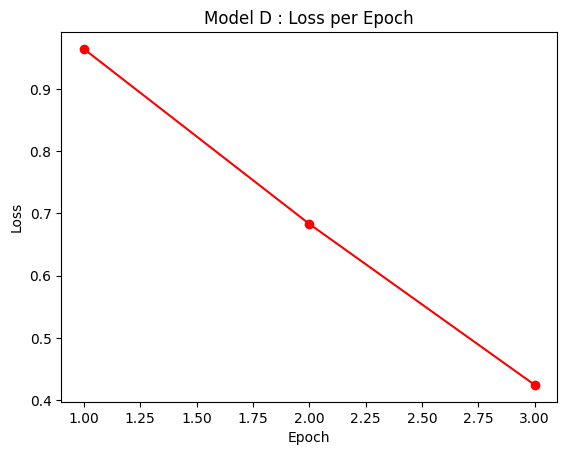

In [ ]:
# Plot the losses per epoch
plt.plot([i+1 for i in range(len(epoch_losses))], epoch_losses, 'r-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model D : Loss per Epoch')
plt.show()